In [5]:
import torch
import sys
import os
from tqdm import tqdm
import numpy as np
sys.path.append(".")
import seaborn as sns


/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-09-11 09:51:09,673] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [10]:
#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path = 'output/alpaca-data-pt-br_300_fedavg_c60s2_i10_b16a1_l512_r8a16_20240911071731/clients_adapters'
DEVICE = 'cuda'

In [13]:
def get_adapter(path, client, round = 50, layer = -1):
    adapter_path = path + f'/checkpoint-{round}_client{client}/adapter_model.bin' # Replace with your actual adapter checkpoint path

    # Load the adapter weights from the checkpoint
    adapter_state_dict = torch.load(adapter_path, map_location='cpu')

    # Access the adapter weights (as tensors)
    adapter_weights_A = [param for name, param in adapter_state_dict.items() if 'lora_A' in name]
    adapter_weights_B = [param for name, param in adapter_state_dict.items() if 'lora_B' in name]

    adapter_weights_A = adapter_weights_A[-1]
    adapter_weights_B = adapter_weights_B[-1]

    #flatten
    adapter_weights_A = adapter_weights_A.flatten()
    adapter_weights_B = adapter_weights_B.flatten()

    return adapter_weights_A, adapter_weights_B

In [19]:
similarity_A = np.zeros((60,60))
similarity_B = np.zeros((60,60))

for c1 in list(range(60)):
    print(f'Calculating similarity for {c1}')
    adapter_weights_A_c1, adapter_weights_B_c1 = get_adapter(path, client = c1, round = 50, layer = -1) 
    adapter_weights_A_c1 = adapter_weights_A_c1.cpu()
    adapter_weights_B_c1 = adapter_weights_B_c1.cpu()

    for c2 in list(range(60)):
        adapter_weights_A_c2, adapter_weights_B_c2 = get_adapter(path, client = c2, round = 50, layer = -1)
        adapter_weights_A_c2 = adapter_weights_A_c2.cpu()
        adapter_weights_B_c2 = adapter_weights_B_c2.cpu()
        
        #cosine similarity
        cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        cos_A = cos(adapter_weights_A_c1, adapter_weights_A_c2)
        cos_B = cos(adapter_weights_B_c1, adapter_weights_B_c2)
        similarity_A[c1][c2] = cos_A
        similarity_B[c1][c2] = cos_B

Calculating similarity for 0
Calculating similarity for 1
Calculating similarity for 2
Calculating similarity for 3
Calculating similarity for 4
Calculating similarity for 5
Calculating similarity for 6
Calculating similarity for 7
Calculating similarity for 8
Calculating similarity for 9
Calculating similarity for 10
Calculating similarity for 11
Calculating similarity for 12
Calculating similarity for 13
Calculating similarity for 14
Calculating similarity for 15
Calculating similarity for 16
Calculating similarity for 17
Calculating similarity for 18
Calculating similarity for 19
Calculating similarity for 20
Calculating similarity for 21
Calculating similarity for 22
Calculating similarity for 23
Calculating similarity for 24
Calculating similarity for 25
Calculating similarity for 26
Calculating similarity for 27
Calculating similarity for 28
Calculating similarity for 29
Calculating similarity for 30
Calculating similarity for 31
Calculating similarity for 32
Calculating similari

<Axes: >

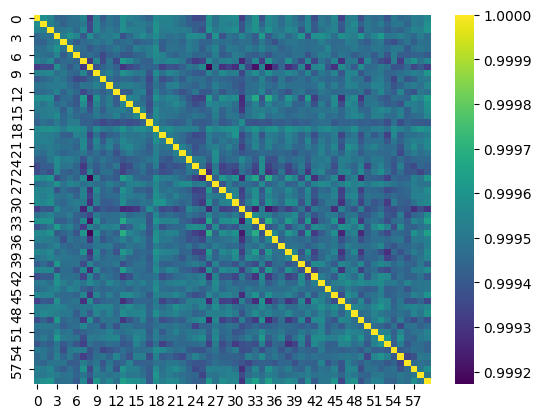

In [22]:
sns.heatmap(similarity_A, cmap='viridis')

<Axes: >

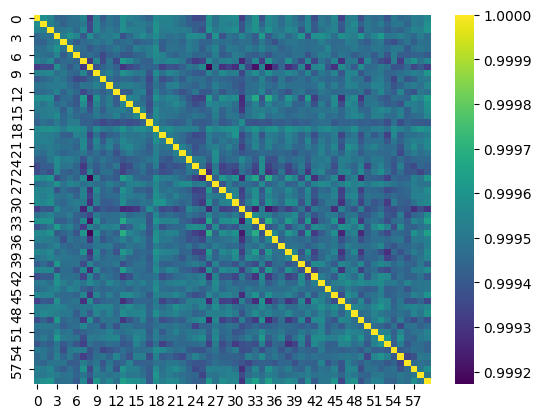

In [23]:
sns.heatmap(similarity_A, cmap='viridis')